# Support Vector Machines (SVM) - Hard Margin Case
---
Recall the binary classification problem that SVMs try to solve. The hard margin SVM finds the seperating decision bounary with the largest margin. 

<img src="MaxMargin.jpg" height="400" width="400">

In this assigment, you will write the code to find the maximum margin for the hard margin case.

We showed in class that we could solve this problem  by reducing it to the problem of solving a quadratic programming problem (QP).  There are many solvers for quadratic programming problems. We will use the *Convex Optimization Library*, [CVXOPT](https://cvxopt.org/userguide/coneprog.html#quadratic-programming); a free software package that works well with Python and numpy. 
You will need to install [CVXOPT](https://cvxopt.org/install/)

In CVXOPT, the quadratic programming problem solver, <b><i>cvxopt.solvers.qp</i></b>,  solves the following problem:

$$\begin{eqnarray} \min_{x}\frac{1}{2} x^{T}Px - q^{T}x \nonumber \\\ \textrm{s.t.}\quad Gx \preceq h \\\ \textrm{and}\quad Ax = b \end{eqnarray}$$

 Note that $ Gx \preceq h $ is taken elementwise. 

The solver's (simplified) API is `cvxopt.solvers.qp(P, q, G, h, A, b)` 
where only $P$ and $q$ are required. 

You will need to match the solver's API.

The solver's argument's type must be CVXOPT matrices.  Please look at this [link](https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf) for more information. I suggest you first create the arguments as NumpPy arrays and matrices and then convert them to CVXOPT matrices (For example, first import the library: `from cvxopt import matrix` then convert a NumPy matrix `P` to a CVXOPT matrix using ` P = matrix(P)`)

What is return by the solver  is a Python dictionary.  If you save the return value in a variable called `sol` (i.e. `sol = solvers.qp(...)`), you can access to the solution of the quadratic programming problem by typing `sol["x"]`.

# Hard Margin Case

 We will use synthetic data. The following code will reads the linearly sepearable data and plots the points.


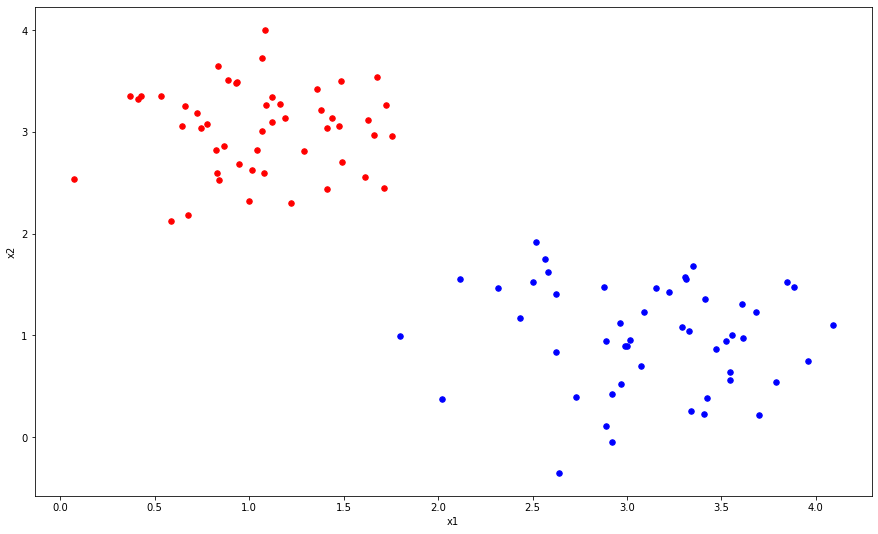

<class 'numpy.ndarray'>
(100, 2)
<class 'numpy.ndarray'>
(100,)


In [32]:
import numpy as np
import csv
from numpy import genfromtxt
import matplotlib.pyplot as plt
%matplotlib inline


X = genfromtxt('X.csv', delimiter=',') # reading in the data matrix
y = genfromtxt('y.csv', delimiter=',') # reading in the labels
idx_1 = np.where(y == 1)
idx_0 = np.where(y == -1)

plt.figure(figsize=(15,9))
plt.scatter(X[idx_1,0], X[idx_1,1], s=30, c='b', marker="o")
plt.scatter(X[idx_0,0], X[idx_0,1], s=30, c='r', marker="o")
plt.xlabel('x1')
plt.ylabel('x2');

plt.show()
print(type(X));print(X.shape);
print(type(y));print(y.shape);

## SVM Primal  Problem
---
### Problem 1.1

You will now use the quadratic problem solver to find the maximum margin for the SVM primal problem:

$$\begin{eqnarray}\left.\begin{aligned}  
&\min_{w}\frac{1}{2}||w||^{2} & \nonumber \\\ 
&\textrm{s.t.}  \quad y^{(i)}(w^{T}{\bf x}^{(i)} + w_0) \ge 1 \quad \forall i \end{aligned}\right.\end{eqnarray}$$


Look back at the lecture notes for the primal problem.  Please note that the variable names used in the lecture are different from the variable names given to decribe the API for CVXOPT's quadratic problem solver.




 Write the function `linear_svm(X, y)` that:
- takes in as arguments the data matrix $X$ and the labels $\bf y$ 
- solves the SVM primal QP problem 
- returns  ${\bf w}$ and $w_0$

In [33]:
from cvxopt import matrix, solvers

def linear_svm(X,y):
    solvers.options['show_progress'] = False
    weights = []
    P = np.identity(X.shape[1]+1)
    P[0][0] = 0.
    P = matrix(P)
    q = matrix(np.zeros(X.shape[1]+1))
    ones = np.ones(X.shape[0]).reshape((X.shape[0], 1))
    X = np.hstack((ones, X))
    G = (-1) * matrix((X.T * y).T)
    h = matrix([-1.]*X.shape[0])
    sol = solvers.qp(P, q, G, h)
    for i in range(X.shape[1]):
        weights.append(sol['x'][i])
    weights = np.array(weights)
    return weights

# fit svm classifier
weights = linear_svm(X, y)
w0 = weights[0]
w = weights[1:3]
print("w0 = {}".format(w0))
print("w = {}".format(w))

w0 = 0.46118098859684725
w = [ 1.42189318 -1.58830104]


### Plotting the classification decision boundary

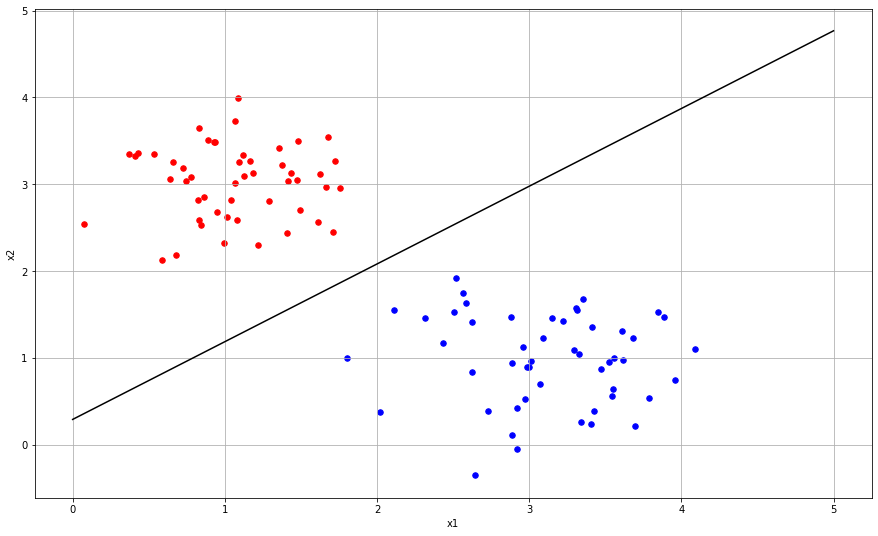

In [34]:
def plot_data_with_classification_boundary(X, y, w, w0, fig_size=(15, 9), labels=['x1', 'x2']):
    COLORS = ['blue', 'red']
    unique = np.unique(y)
    idx_1 = np.where(y == unique[1])
    idx_0 = np.where(y == unique[0])

    plt.figure(figsize=fig_size)
    plt.scatter(X[idx_1, 0], X[idx_1, 1], s=30, c=COLORS[0], marker="o")
    plt.scatter(X[idx_0, 0], X[idx_0, 1], s=30, c=COLORS[1], marker="o")
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    slope = -w[0] / w[1]
    intercept = -w0 / w[1]
    x = np.arange(0, 6)
    plt.plot(x, x * slope + intercept, 'k-')
    plt.grid()
    plt.show()

# plotting the points and decision boundary   
plot_data_with_classification_boundary(X, y, w, w0)

### Problem 1.2 
Determine which points are closest to the decision boundary. What is the functional margin of the points closest to the decision boundary?   

support vectors and their labels:
[2.11457352 1.5537852 ] 1.0
[2.51879639 1.91565724] 1.0
[1.71138733 2.45204836] -1.0


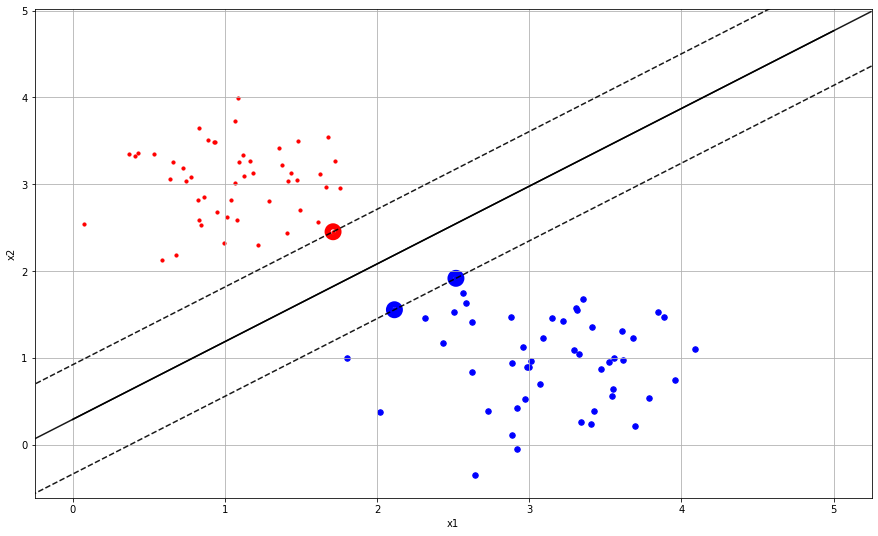

In [35]:
# functional margin must be 1

def getSupportVectors(X, y, w0, w):
    """
    return the indices of supprot vectors
    """
    res = []
    for i in range(X.shape[0]):
        temp = ((w.T.dot(X[i]) + w0)*y[i]).item()
        if abs(temp - 1) <= 10**-5:
            res.append(i)
    return res

def plot_supprot_vectors(X, y, w, w0, indices, fig_size=(15, 9), labels=['x1', 'x2']):
    unique = np.unique(y)
    
    idx_1 = np.where(y == 1)
    idx_0 = np.where(y == -1)

    plt.figure(figsize=(15,9))
    plt.scatter(X[idx_1,0], X[idx_1,1], s=30, c='b', marker="o")
    plt.scatter(X[idx_0,0], X[idx_0,1], s=10, c='r', marker="o")
    plt.xlabel('x1')
    plt.ylabel('x2');
            
    slope = -w[0] / w[1]
    intercept = -w0 / w[1]
    x = np.arange(0, 6)
    plt.plot(x, x * slope + intercept, 'k-')
    
    for i in indices:
        color = 'b'
        if y[i] == -1:
            color = 'r'
        plt.scatter(X[i][0], X[i][1], s=120, linewidth=6, facecolors='none', 
                    edgecolors=color)
    
    ax = plt.gca()
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(x_lim[0], x_lim[1], 50),
                         np.linspace(y_lim[0], y_lim[1], 50))
    xx, yy = np.array(xx), np.array(yy)
    xx_in_row, yy_in_row = xx.ravel(), yy.ravel()
    X_mesh = np.column_stack((xx_in_row.reshape(-1,1), yy_in_row.reshape(-1,1)))
    y_mesh = np.ones(X_mesh.shape[0]).reshape((-1, 1))
    temp_mesh = y_mesh * X_mesh
    A_mesh = (np.column_stack((y_mesh, temp_mesh)))
    wei = np.column_stack((np.array(w0).reshape((1,-1)), np.array(w).reshape((1,-1))))
    Z = A_mesh.dot(wei.reshape((-1, 1)))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1.0, 0, 1.0], alpha=0.9, linestyles=['--', '-', '--'])

    plt.grid()
    plt.show()

indices = getSupportVectors(X, y, w0, w)
print("support vectors and their labels:")
for i in indices:
    print(X[i], y[i])
plot_supprot_vectors(X, y, w, w0, indices)

### Problem 1.3

Write the decision function $f_{\texttt{primal}}({\bf x})$ to predict examples.  Use this function to predict the label of $(3.0, 1.5)^T$ and $(1.2, 3.0)^T$

In [36]:
def f_primal(x):
    return w0 + w.T.dot(x)

print("Decision Boundary: 0.46 + 1.42x1 - 1.59x2 = 0")
print()

# the label of data above the decision boundary is -1
# so we multiply -1 to reverse the result when predict
x1 = np.array([3.0, 1.5])
y1 = 1 if f_primal(x1) >= 0 else -1
x2 = np.array([1.2, 3.0])
y2 = 1 if f_primal(x2) >= 0 else -1
print("The label of x1(3.0, 1.5) is {}".format(y1))
print("The label of x2(1.2, 3.0) is {}".format(y2))

Decision Boundary: 0.46 + 1.42x1 - 1.59x2 = 0

The label of x1(3.0, 1.5) is 1
The label of x2(1.2, 3.0) is -1


## SVM Dual Problem

---

To keep things simple, we will use a linear kernel $K({\bf x}^{(i)}, {\bf x}^{(j)})={\bf x}^{(i)T}{\bf x}^{(j)}$.  In the statement of the problem below, I replaced ${\bf x}^{(i)}$ with $\phi({\bf x}^{(i)})$ as was done in the lecture notes.

### Problem 2.1
The SVM dual problem was derived in class by:
- defining the lagrangian of the Primary problem: $L = \frac{1}{2}||w||^{2} - \sum_{i} \alpha^{(i)} [y^{(i)}(w^{T}\phi({\bf x}^{(i)}) + w_0)-1]$
- equating it's partial derivatives with respect to $w$ and $w_0$ to zero, and 
- substituting $w$ back into the lagrangian.

It resulted in a quadratic programming problem (QP) of the following form:

$$\begin{eqnarray}\left.\begin{aligned}  
&\min_{\alpha}\frac{1}{2} \alpha^{T}Q\alpha - 1^{T}\alpha \nonumber \\\ &\textrm{s.t.}\quad \alpha_{i} \ge 0 \quad \forall i \\\ 
&\:\:\:\:\:\quad y^{T}\alpha = 0 \end{aligned}\right.\end{eqnarray}$$




 Write the function `kernel_svm(x, y)`that:
- takes in as arguments: the data matrix $X$, the labels $y$ 
- solves the SVM dual QP problem using a linear kernel
- returns:  ${\bf \alpha}$

In [37]:
def linear_kernel(X_i, X_j): # at least should be a column vector
    return np.transpose(X_i).dot(X_j)

def kernel_svm(X, y):
    N = len(y)
    alphas = []
    y = y.reshape(-1, 1)
    yX = y * X
    P = yX.dot(yX.T)
    P = matrix(P)
    q = matrix((-1) * np.ones(X.shape[0]).reshape((X.shape[0], 1)))
    G = matrix((-1) * np.identity(X.shape[0]))
    h = matrix(np.zeros(X.shape[0]))
    A = matrix(y.T)
    b = matrix(np.zeros(1))
    sol = solvers.qp(matrix(P), matrix(q), matrix(G), matrix(h), matrix(A), matrix(b))
    
    for i in range(N):
        alphas.append(sol['x'][i])
    alphas = np.array(list(map(lambda x: x if x > 1/1000 else 0, alphas)))
    return alphas

# fit svm dual classifier
alphas = kernel_svm(X, y)

Treat any $\alpha^{(i)} \le 1/1000$ as $0$.

### problem 2.2 

Write a function `compute_w (X, y, alpha)` that: 
- takes in as arguments the data matrix $X$, labels ${\bf y}$, and ${\bf \alpha}$ 
- returns ${\bf w}$ and $w_0$ 

Compare this ${\bf w}$ and $w_0$ computed by the dual with the ${\bf w}$ and $w_0$ computed by the primal

In [38]:
def compute_classification_boundary(X, y, alpha):
    w = (np.array(y)*alpha).dot(X)
    indices = [list(alpha).index(al) for al in list(alpha) if al != 0]
    index = indices[0]
    w0 = y[index] - X[index].dot(w.reshape((-1, 1)))
    return w, w0

# compute w and w0
w, w0 = compute_classification_boundary(X, y, alphas)
print("w0 = {}".format(w0))
print("w = {}".format(w))

w0 = [0.46118097]
w = [ 1.42189318 -1.58830104]


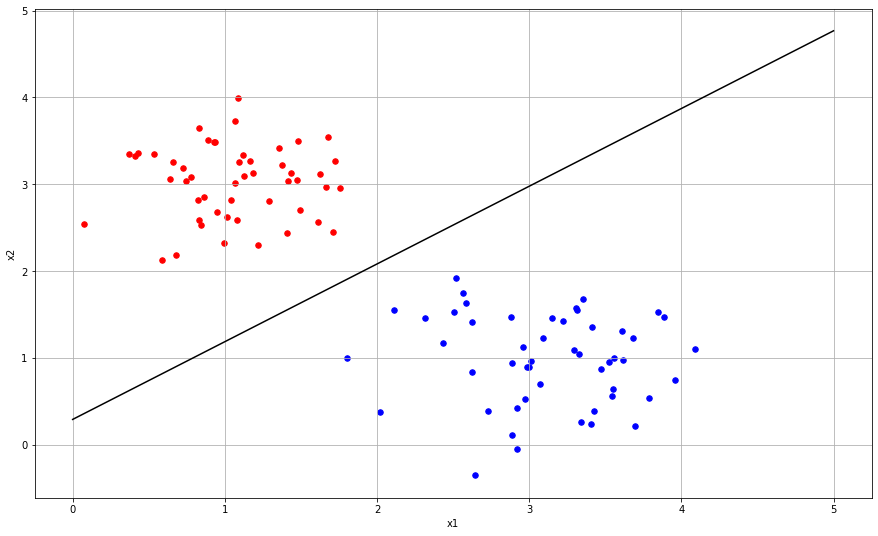

In [39]:
plot_data_with_classification_boundary(X, y, w, w0)

### Problem 2.3 

Write the code to determine which of the training examples are support vectors.  Write the code to determine the functional margin of the support vectors.

support vectors and their labels:
[2.11457352 1.5537852 ] 1.0
[2.51879639 1.91565724] 1.0
[1.71138733 2.45204836] -1.0


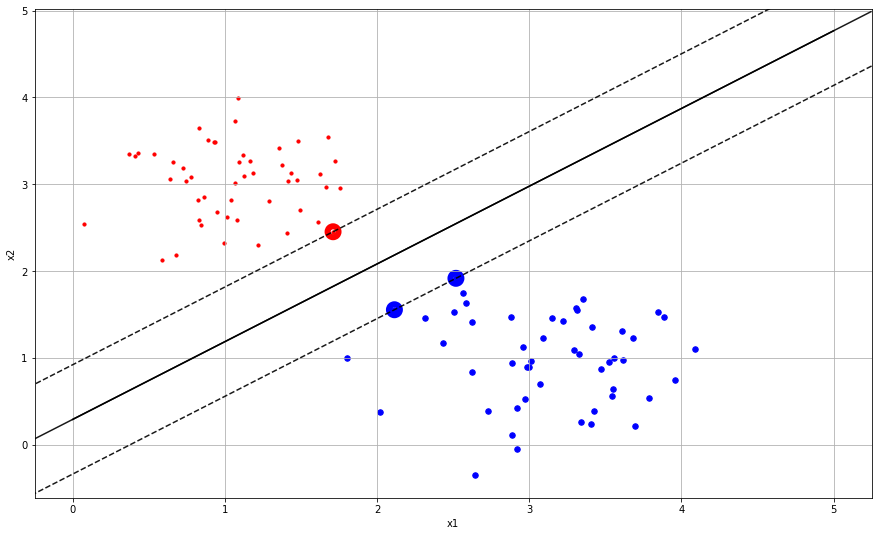

In [40]:
indices = getSupportVectors(X, y, w0, w)
print("support vectors and their labels:")
for i in indices:
    print(X[i], y[i])
plot_supprot_vectors(X, y, w, w0, indices)

### Problem 2.4

Write the decision function $f_{\texttt{dual}}({\bf x})=
\left(\sum_{i\in I}
\alpha^{(i)}y^{(i)}
K({\bf x}^{(i)},{\bf x})
\right)+w_0$ 
where $I = \{i\mid \alpha^{(i)}\not = 0\}$.  The kernel function will be the linear kernel.  Use the decision function to predict the class of $(3.0, 1.5)^T$ and $(1.2, 3.0)^T$


In [41]:
def K(xi, xj):
    return np.dot(xi,xj)

def f_dual(x):
    return w0 + w.T.dot(x)

print("f_dual is: 0.46 + 1.42x1 - 1.59x2 = 0")
print()

# write the code to predict (3.0, 1.5)^T and (1.2, 3.0)^T here
x1 = np.array([3.0, 1.5])
y1 = 1 if f_dual(x1) >= 0 else -1
x2 = np.array([1.2, 3.0])
y2 = 1 if f_dual(x2) >= 0 else -1
print("The label of x1 is {}".format(y1))
print("The label of x2 is {}".format(y2))

f_dual is: 0.46 + 1.42x1 - 1.59x2 = 0

The label of x1 is 1
The label of x2 is -1


# Experiment on your own
Do not turn in this part.  You can try to solve the soft margin case and add different kernels